## Experiment Setup

###  Random seed / Colab / CUDA related

In [1]:
import time
import datetime
import sys
import os

# Use Google Colab
use_colab = True

# Is this notebook running on Colab?
# If so, then google.colab package (github.com/googlecolab/colabtools)
# should be available in this environment

# Previous version used importlib, but we could do the same thing with
# just attempting to import google.colab
try:
    from google.colab import drive
    colab_available = True
except:
    colab_available = False

if use_colab and colab_available:
    drive.mount('/content/drive')
    
    # If there's a package I need to install separately, do it here
    !pip install pyro-ppl

    # cd to the appropriate working directory under my Google Drive
    %cd 'drive/My Drive/Colab Notebooks/bayesian-dl-experiments'
    
    # List the directory contents
    !ls

# IPython reloading magic
%load_ext autoreload
%autoreload 2

# Random seeds
# Based on https://pytorch.org/docs/stable/notes/randomness.html
random_seed = 682

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/bayesian-dl-experiments
experiment_comparison_toy.ipynb  LICENSE    ronald_bdl
experiment_nn_capacity_1.ipynb	 README.md  test_results


### Third party libraries (NumPy, PyTorch, Pyro)

In [2]:
# Third party libraries import
import numpy as np
import torch
import pyro
import matplotlib.pyplot as plt

# Print version information
print("Python Version: " + sys.version)
print("NumPy Version: " + np.__version__)
print("PyTorch Version: " + torch.__version__)
print("Pyro Version: " + pyro.__version__)

Python Version: 3.6.8 (default, Oct  7 2019, 12:59:55) 
[GCC 8.3.0]
NumPy Version: 1.17.4
PyTorch Version: 1.3.1
Pyro Version: 1.0.0


In [3]:
# More imports...
from torch.utils.data import random_split, DataLoader
from ronald_bdl import datasets, models
from pyro.infer import SVI, Trace_ELBO, HMC, MCMC

# pyplot setting
%matplotlib inline

# torch.device / CUDA Setup
use_cuda = True

if use_cuda and torch.cuda.is_available():
    torch_device = torch.device('cuda')

    torch.backends.cudnn.deterministic = True
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = False
    use_pin_memory = True # Faster Host to GPU copies with page-locked memory

    # CUDA libraries version information
    print("CUDA Version: " + str(torch.version.cuda))
    print("cuDNN Version: " + str(torch.backends.cudnn.version()))
else:
    torch_device = torch.device('cpu')
    use_pin_memory = False

CUDA Version: 10.1.243
cuDNN Version: 7603


### Toy dataset settings

In [0]:
"""
Toy dataset generation based on the experiment from 
the Probabilstic Backpropagation paper (Hernandez-Lobato & Adams, 2015)
"""

# Random seed for toy dataset
dataset_toy_random_seed = 691

# Toy dataset size
dataset_toy_size = 20

# Toy dataset x distribution (uniform) parameters
dataset_toy_x_low = -4
dataset_toy_x_high = 4

# Toy dataset y distribution (normal with noise)
dataset_toy_y_mean = 0
dataset_toy_y_std = 9

### MC dropout parameters

In [0]:
"""
MC Dropout related
"""

# Dropout rate
dropout_rate = 0.5

# L2 regularization strength
reg_strength = 0.3

# Epochs
n_epochs = 4000

# Optimizer learning rate
learning_rate = 0.01

# Loss function type
loss_function_type = 'mse_loss'

# Number of test predictions (for each data point)
n_predictions = 10000

### Directory path to save results

In [0]:
# Test start time
test_start_time = datetime.datetime.today().strftime('%Y%m%d%H%M')

# Directory to store the results for this experiment
test_results_path = os.path.join(
    './test_results',
    'comparison_toy',
    (
        test_start_time 
        + '_' + str(n_epochs) 
        + '_' + str(dropout_rate) 
        + '_' + str(reg_strength) 
        + '_' + str(loss_function_type) 
        + '_' + str(n_predictions))
)

# Create the directory if it doesn't exist
os.makedirs(test_results_path, exist_ok=True)

## Prepare data

### Get the data as a torch Dataset object

In [7]:
dataset = datasets.ToyDatasets(
    random_seed=dataset_toy_random_seed,
    n_samples=dataset_toy_size,
    x_low=dataset_toy_x_low,
    x_high=dataset_toy_x_high,
    y_mean=dataset_toy_y_mean,
    y_std=dataset_toy_y_std,
)

# Get the test data
X_test = torch.linspace(dataset_toy_x_low, dataset_toy_x_high, 100).reshape(100, 1)

# Print the size of the training set
print("dataset size = " + str((len(dataset), dataset.n_features)))

dataset size = (20, 1)


## Define network

In [0]:
uncertainty_methods = {}

# MC (Bernoulli) dropout
uncertainty_methods['mc_dropout'] = models.FCNetMCDropout(
    input_dim=dataset.n_features, 
    output_dim=dataset.n_targets,
    hidden_dim=100,
    n_hidden=0,
    dropout_rate=dropout_rate,
    dropout_type='bernoulli',
)

# Vanilla Variational Inference
uncertainty_methods['vi'] = models.FCNetPyro(
    input_dim=dataset.n_features, 
    output_dim=dataset.n_targets,
    hidden_dim=100,
    n_hidden=0,
    torch_device=torch_device,
)

# HMC (NUTS)
uncertainty_methods['hmc'] = models.FCNetPyro(
    input_dim=dataset.n_features, 
    output_dim=dataset.n_targets,
    hidden_dim=100,
    n_hidden=0,
    torch_device=torch_device,
)

## Train the network

### Train/test the model

In [9]:
for key, network in uncertainty_methods.items():
    # Reset the random number generator for each method (to produce identical results)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    pyro.set_rng_seed(random_seed)
    
    # Print the method name
    print("Now running " + str(key))
    
    # Send the whole model to the selected torch.device
    network.to(torch_device)

    # Print the network structure
    print(network)
    print()

    # Initialize training data loader
    train_loader = DataLoader(dataset, batch_size=len(dataset))
    
    """
    Optimizer Setup
    """

    if isinstance(network, models.FCNetMCDropout):
        # Adam optimizer
        # https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam
        # NOTE: Need to set L2 regularization from here
        optimizer = torch.optim.Adam(
            network.parameters(),
            lr=learning_rate,
            weight_decay=reg_strength, # L2 regularization
        )

        # Mean Squared Error for loss function to minimize
        objective = torch.nn.MSELoss()

    elif isinstance(network, models.FCNetPyro):
        pyro.clear_param_store()

        if use_cuda and torch.cuda.is_available():
            torch.set_default_tensor_type(torch.cuda.FloatTensor)
        if key == 'vi':
            optimizer = pyro.optim.Adam({"lr": 0.03})
            svi = SVI(network, network.guide, optimizer, loss=Trace_ELBO())
        elif key == 'hmc':
            kernel = HMC(network)
            mcmc = MCMC(kernel, num_samples=30000)

    """
    Training
    """

    # Model to train mode
    network.train()

    # Record training start time (for this method)
    tic = time.time()
    
    if key == 'hmc':
        # to() actually returns new Tensor; need to replace with that return
        dataset.data_x = dataset.data_x.to(torch_device)

        dataset.data_y = dataset.data_y.to(torch_device)

        mcmc.run(dataset.data_x, dataset.data_y)
    else:
        for epoch in range(n_epochs): # loop over the dataset multiple times

            for i, data in enumerate(train_loader):
                # get the inputs; data is a list of [inputs, labels]
                inputs, targets = data

                # Store the batch to torch_device's memory
                # to() actually returns new Tensor; need to replace with that return
                inputs = inputs.to(torch_device)
                targets = targets.to(torch_device)

                if isinstance(network, models.FCNetMCDropout):
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward + backward + optimize
                    outputs = network(inputs)

                    if loss_function_type in ('test_ll_mc', 'rmse_mc'):
                        _, _, _, metrics = network.predict_dist(
                            inputs, n_predictions, y_test=targets, reg_strength=reg_strength)

                        if loss_function_type == 'test_ll_mc':
                            total_loss = -(metrics[loss_function_type])
                    else:
                        total_loss = objective(outputs, targets)

                    total_loss.backward()

                    optimizer.step()

                elif isinstance(network, models.FCNetPyro):
                    pyro.clear_param_store()
                    # calculate the loss and take a gradient step
                    total_loss = svi.step(inputs, targets)

            if epoch % 100 == 0:
                print("[iteration %04d] loss: %.4f" % (epoch + 1, total_loss))
            
    # Record training end time
    toc = time.time()

    # Report the final loss
    print("final loss = " + str(total_loss))            

    # Report the total training time
    print("training time = " + str(toc - tic) + " seconds")
    
    print()

Now running mc_dropout
FCNetMCDropout(
  (input): ModuleDict(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear): Linear(in_features=1, out_features=100, bias=True)
    (relu): ReLU()
  )
  (output): Linear(in_features=100, out_features=1, bias=True)
)

[iteration 0001] loss: 541.7947
[iteration 0101] loss: 181.2648
[iteration 0201] loss: 135.8599
[iteration 0301] loss: 148.7037
[iteration 0401] loss: 144.8909
[iteration 0501] loss: 103.6205
[iteration 0601] loss: 93.3496
[iteration 0701] loss: 96.9266
[iteration 0801] loss: 97.1319
[iteration 0901] loss: 110.2934
[iteration 1001] loss: 80.8576
[iteration 1101] loss: 108.3147
[iteration 1201] loss: 80.9675
[iteration 1301] loss: 97.3605
[iteration 1401] loss: 101.3212
[iteration 1501] loss: 93.5688
[iteration 1601] loss: 71.4447
[iteration 1701] loss: 82.7061
[iteration 1801] loss: 108.1115
[iteration 1901] loss: 90.9474
[iteration 2001] loss: 102.7028
[iteration 2101] loss: 63.4164
[iteration 2201] loss: 72.8141
[iteration 2301

Warmup:   0%|          | 0/60000 [00:00, ?it/s]

final loss = 60651.9414151907
training time = 15.736900568008423 seconds

Now running hmc
FCNetPyro(
  (input): PyroModuleDict(
    (linear): PyroLinear(in_features=1, out_features=100, bias=True)
    (relu): PyroReLU()
  )
  (output): PyroLinear(in_features=100, out_features=1, bias=True)
  (guide): AutoDiagonalNormal()
)



Sample: 100%|██████████| 60000/60000 [12:03, 82.98it/s, step size=9.22e-01, acc. prob=0.961]


final loss = 60651.9414151907
training time = 723.1546485424042 seconds



testing time = 1.261894702911377 seconds

Mean = tensor([-49.2314, -47.8516, -46.3250, -44.7769, -43.2560, -41.8764, -40.2582,
        -38.6727, -37.2313, -35.7427, -34.2773, -32.7401, -31.1943, -29.7305,
        -28.2125, -26.5876, -25.1236, -23.6109, -22.1045, -20.6063, -19.0660,
        -17.5217, -15.9992, -14.5072, -13.0015, -11.4508,  -9.9840,  -8.6071,
         -7.3571,  -6.3691,  -5.4625,  -4.7104,  -4.1623,  -3.7031,  -3.2872,
         -2.9075,  -2.5528,  -2.2404,  -1.9394,  -1.6417,  -1.2993,  -0.9733,
         -0.6411,  -0.2810,   0.0752,   0.4371,   0.8067,   1.1502,   1.4869,
          1.7978,   2.0956,   2.3489,   2.5428,   2.7007,   2.8274,   2.9424,
          3.0439,   3.1281,   3.2186,   3.3004,   3.3848,   3.4741,   3.5426,
          3.6421,   3.7336,   3.8130,   3.8995,   3.9817,   4.0676,   4.2245,
          4.4072,   4.5500,   4.7032,   4.9065,   5.2361,   5.6779,   6.2241,
          6.9476,   8.0276,   9.3712,  10.8146,  12.5310,  14.3355,  16.2308,
         18.360

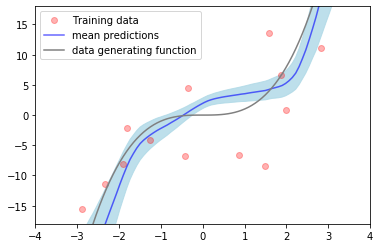

testing time = 6.292339563369751 seconds

Mean = tensor([-53.9876, -52.8315, -51.6291, -50.4449, -49.3352, -48.1686, -47.0480,
        -45.8481, -44.7170, -43.5822, -42.4430, -41.3031, -40.2915, -39.1457,
        -38.1430, -37.0899, -35.9777, -34.8658, -33.8321, -32.8132, -31.6922,
        -30.6775, -29.7791, -28.6809, -27.7973, -26.8586, -26.0020, -24.9776,
        -24.1513, -23.1804, -22.2993, -21.3772, -20.4707, -19.6408, -18.7209,
        -17.7925, -16.8839, -15.8187, -14.8143, -13.7571, -12.6435, -11.6533,
        -10.5206,  -9.6339,  -8.8581,  -8.3505,  -7.9086,  -7.6066,  -7.3301,
         -7.1618,  -6.9203,  -6.5851,  -6.4333,  -6.4445,  -6.4615,  -6.3920,
         -6.4108,  -6.4231,  -6.4683,  -6.4236,  -6.5209,  -6.6429,  -6.9052,
         -7.1149,  -7.4505,  -7.8073,  -8.2970,  -8.7922,  -9.2610,  -9.6307,
        -10.1496, -10.6960, -11.1999, -11.5622, -11.9241, -12.2951, -12.6019,
        -12.9216, -13.3443, -13.7720, -14.2465, -14.7158, -15.1158, -15.5371,
        -16.078

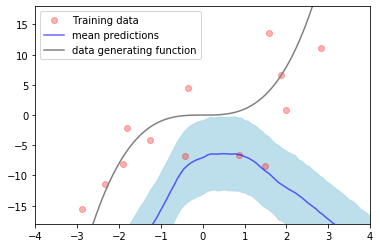

testing time = 6.251548767089844 seconds

Mean = tensor([-3.5950e+01, -3.5270e+01, -3.4662e+01, -3.3994e+01, -3.3311e+01,
        -3.2624e+01, -3.2001e+01, -3.1363e+01, -3.0679e+01, -2.9994e+01,
        -2.9326e+01, -2.8715e+01, -2.8055e+01, -2.7425e+01, -2.6729e+01,
        -2.6107e+01, -2.5432e+01, -2.4815e+01, -2.4140e+01, -2.3442e+01,
        -2.2934e+01, -2.2256e+01, -2.1598e+01, -2.0973e+01, -2.0272e+01,
        -1.9511e+01, -1.8894e+01, -1.8290e+01, -1.7718e+01, -1.7045e+01,
        -1.6583e+01, -1.5999e+01, -1.5296e+01, -1.4573e+01, -1.3743e+01,
        -1.2971e+01, -1.2161e+01, -1.1460e+01, -1.0676e+01, -9.7989e+00,
        -8.9835e+00, -8.1665e+00, -7.3095e+00, -6.6539e+00, -6.0175e+00,
        -5.3087e+00, -4.6552e+00, -4.1480e+00, -3.6692e+00, -3.2724e+00,
        -2.8245e+00, -2.6094e+00, -2.4376e+00, -2.0889e+00, -1.7761e+00,
        -1.4455e+00, -1.2281e+00, -8.2420e-01,  8.6072e-03,  9.5660e-01,
         1.6449e+00,  2.3015e+00,  2.9988e+00,  3.6059e+00,  4.1877e+00,
  

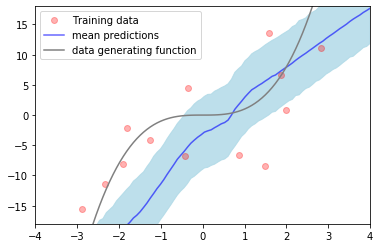

In [10]:
X_test = X_test.to(torch_device)
X_test_cpu = X_test.cpu()

for key, network in uncertainty_methods.items():

    """
    Testing
    """

    # Model to eval mode
    network.eval()

    # Record testing start time (for this split)
    tic_testing = time.time()    

    predictions, mean, var, metrics = network.predict_dist(X_test, n_predictions)
    
    # Record testing end time
    toc_testing = time.time()
    
    # Report the total testing time
    print("testing time = " + str(toc_testing - tic_testing) + " seconds")

    # These can now be stored in CPU memory
    predictions = predictions.cpu()
    mean = mean.cpu()
    var = var.cpu()
    
    """
    Print results
    """

    print()
    print("Mean = " + str(mean.flatten()))
    print("Variance = " + str(var.flatten()))
    
    # store additional metrics
    if len(metrics) > 0:
        for key, value in metrics.items():
            print(str(key) + " = " + str(value))
        print()
             
    # Plot the uncertainty measured by each methods
    plt.figure()
    
    # Fix the scales of x-axis and y-axis
    plt.xlim(dataset_toy_x_low, dataset_toy_x_high)
    plt.ylim(dataset_toy_y_mean-2*dataset_toy_y_std, dataset_toy_y_mean+2*dataset_toy_y_std)

    # Distributions around the predictions
    plt.fill_between(
        X_test_cpu.flatten(), 
        (mean.detach().numpy() - 2*torch.sqrt(var).detach().numpy()).flatten(),
        (mean.detach().numpy() + 2*torch.sqrt(var).detach().numpy()).flatten(),
        color='lightblue', alpha=0.8)

    # Train data
    plt.plot(dataset.data_x.cpu(), dataset.data_y.cpu(), 'or', label='Training data', alpha=0.3)

    # MC prediction
    plt.plot(X_test_cpu, mean.detach().numpy(), 'blue', label='mean predictions', alpha=0.6)
    
    # Original data generating function without noise
    plt.plot(X_test_cpu, X_test_cpu ** 3, 'gray', label='data generating function')    
    
    plt.legend()
    
    plt.savefig(os.path.join(test_results_path, str(key) + '.png'))
    
    plt.show()